# Here is a title
This version join the record of all folder (balance training, unbalance training and eval) together.

## Convert Audio to image

In [1]:
import librosa.display
import librosa

import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')

import numpy as np
from IPython.display import Audio
import csv
import random
import os
import shutil

Create a dataset from the urban sound 8K dataset that contains all engine idling sounds as well as an equal number of random sounds taken from the other categories. Doing so using the UrbanSound8k csv with the labels and IDs of the files


In [32]:
# create a list with all the IDs for car engine idling sounds

us_file = 'UrbanSound8k.csv'
list_ideng_files = []
list_of_other_sounds = []

#set a variable that can be used later. Out of the 8732 files 1000 are idling engine sounds. 
# 12.9% are the amount of files (1000) that are not idling_engine sounds The variable is needed to pick files that are non idling_engine sounds
# with a random probability of 12.9 % in order to create a balanced dataset containing idling_engine and non idling_engine sounds.  
append_probability = 12.93 # 100 / 7732 * 100
random.seed(50)


with open(us_file) as csv_file:
    reader = csv.reader(csv_file)
    
    for line in reader:
        if 'engine_idling' in line:
            list_ideng_files.append(line[0])
        else: 
            # append lines with a probability of 12.9 %
            if random.randint(0,100) <= append_probability: 
                    list_of_other_sounds.append(line[0])
   
                



12.933264355923434
1000
977
1977


In [33]:
    
# copy all files that are found in either one of the two lists.

sound_folder = 'C:/Users/matthias/Documents/Projects/urban_sound_files/keggel_dataset'

# create a list of all files paths from the dataset within the subfolders 

sound_files =[os.path.join(root, file) for root, directories, files in os.walk(sound_folder) for file in files]

destination_folder = 'C:/Users/matthias/Documents/Projects/urban_sound_files/test_data'

# Now copy all files present in the two lists into a new folder (destination folder var)
for path in sound_files:
    filename = os.path.basename(path)
    if filename in (list_ideng_files + list_of_other_sounds):
        destination = os.path.join(destination_folder, filename)
        shutil.copy2(path, destination_folder)

## Create mel spectrograms

First we check one of the samples just to make sure everything is right. We take a look at a waveplot as well as a mel spectrogram.
After that we will create mel spectrograms for each audio file.

In [3]:
# select an audio file as an example
audio_file =  'C:/Users/matthias/Documents/Projects/urban_sound_files/our_dataset/344-3-5-0.wav'


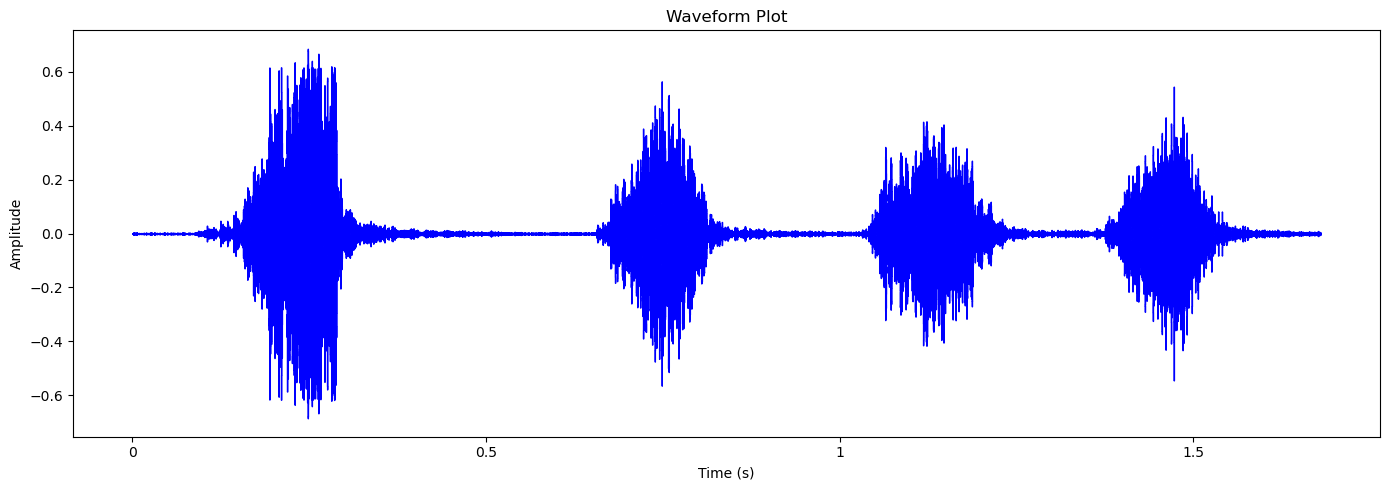

In [4]:


#If samples are not already, convert to np.array, can probably be simpflified, no need for if check

y, sr = librosa.load(audio_file)
if not isinstance(y, np.ndarray):
    samples = np.array(y)


plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr, color='b') #color specification needed due to version incompatibility problems btw librosa and matplotlib
plt.title('Waveform Plot')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.tight_layout()




In [5]:
# Listen to the audio 
Audio(audio_file)


C:\Users\matthias\AppData\Local\Temp\ipykernel_19812\3558297780.py:4: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(sgram)


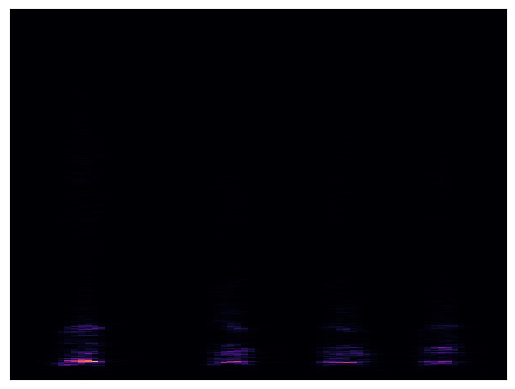

In [6]:
#Apply fourier transformation and plot 

sgram = librosa.stft(y)
librosa.display.specshow(sgram)

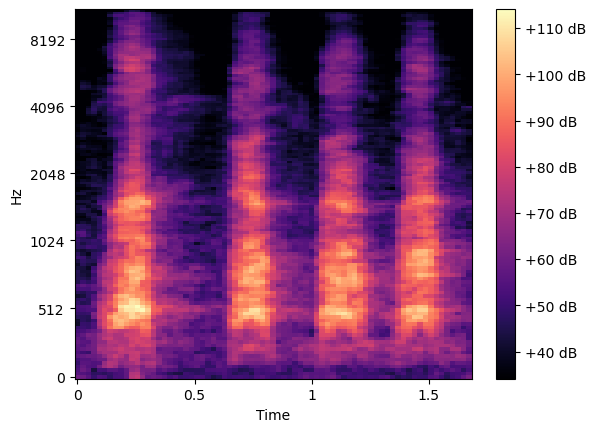

In [9]:
# Create a mel spectrogramm 
sgram_mag, _ = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)
#librosa.display.specshow(mel_scale_sgram)

mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
librosa.display.specshow(mel_sgram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [44]:
def create_mel_specs (path_to_wav, path_to_png):

    #create a list of all wav files needed to be converted: 
    
    file_list = [file for file in os.listdir(path_to_wav)]
    print(file_list)
    
    for file in file_list:    
        
        #create correct file name for saving
        audio_file = os.path.join(path_to_wav, file)
        output_file = os.path.join(path_to_png, os.path.splitext(file)[0] + '.png')
        
        # load the files and transfrom into np array
        samples, sample_rate = librosa.load(audio_file)
        if not isinstance(samples, np.ndarray):
            samples = np.array(samples)
        
        #apply a stft transformation    
        stft = librosa.stft(samples)

        #modify it in order to use the mel-scale instead of frenquency
        mel_scale_spec, par = librosa.magphase(stft)
        mel_spec = librosa.feature.melspectrogram(S=mel_scale_spec, sr=sample_rate)

        # Go from amplitude to db 
        mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.min)

        # create and save the figure
        plt.figure()
        librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sample_rate, fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel Spectrogram with STFT')
        # plt.show()

        plt.savefig(output_file)
                

In [43]:
#apply the function to our dataset

path_to_wav = 'C:/Users/matthias/Documents/Projects/urban_sound_files/our_dataset_mini/'
path_to_png = 'C:/Users/matthias/Documents/Projects/urban_sound_files/mel_specs/'
test = create_mel_specs(path_to_wav, path_to_png)

['344-3-5-0.wav', '4201-3-2-0.wav', '4910-3-0-0.wav', '6508-9-0-1.wav', '6508-9-0-6.wav', '6902-2-0-12.wav', '6902-2-0-9.wav', '6988-5-0-0.wav', '6988-5-0-1.wav', '6988-5-0-2.wav', '6988-5-0-3.wav', '6988-5-0-4.wav', '6988-5-0-5.wav', '7064-6-1-0.wav', '7067-6-0-0.wav', '7383-3-0-0.wav', '7389-1-0-6.wav']


In [23]:


samples, sample_rate = librosa.load(audio_file)
if not isinstance(samples, np.ndarray):
    samples = np.array(samples)
stft = librosa.stft(samples)

mel_scale_spec, par = librosa.magphase(stft)
mel_spec = librosa.feature.melspectrogram(S=mel_scale_spec, sr=sample_rate)

mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.min)

plt.figure()
librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sample_rate, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram with STFT')
# plt.show()

plt.savefig('C:/Users/matthias/Documents/Projects/urban_sound_files/mel_specs/fig1.png')

## Create NNs

In [16]:

# Preprocess and batch the dataset (add any necessary preprocessing here)
batch_size = 100
dataset = dataset.batch(batch_size) 


In [11]:

# Define your model
def define_model (input_shape):
    model = tf.keras.Sequential([
        
        tf.keras.layers.Input(shape=input_shape),
        
        tf.keras.layers.Dense(264, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(1, activation="sgd")
        ])

# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(dataset, epochs=10)
    


In [13]:
# setup tensorboard
root_logdir = os.path.join(os.curdir, 'logs')

tb_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/', histogram_freq=1)



In [14]:
# launch tensorboard
%load_ext tensorboard
%tensorboard --logdir logs/fit
